# Sequential CMS for Continual Learning

This experiment studies **continual learning** using the **Permuted-MNIST** benchmark. A single MLP is trained on a sequence of \(T\) tasks, where each task applies a fixed random pixel permutation to the MNIST inputs. Tasks are learned **sequentially**, one after another, with no access to data from previous tasks once a new task begins.

Two training setups are compared under identical conditions:
- a **baseline** MLP trained with Adam, where all parameters are updated at every step;
- the same MLP trained with **Sequential CMS**, where parameters are split into **fast, mid, and slow groups** and updated at different timescales via an optimizer wrapper.

After training on each task, the model is evaluated on **all tasks seen so far**, producing accuracy matrices that track learning and forgetting over time. The experiment is repeated across multiple random seeds, and results are summarized using **average accuracy** and **average forgetting** metrics.

**Goal:** evaluate whether **multi-timescale optimization alone**, without replay, task identifiers, or architectural changes, can mitigate catastrophic forgetting in a controlled continual learning setting.

**Precondition:** Tu run this notebook you need to first run your experiment and substitute the directory name inside the variable: `EXPERIMENT_NAME`

In [1]:
import json
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

EXPERIMENT_NAME = "optimized_lr"
RESULTS_RAW = Path(f"../results/{EXPERIMENT_NAME}/raw")
RESULTS_SUMMARY = Path(f"../results/{EXPERIMENT_NAME}/summary.json")
FIG_DIR = Path(f"../results/{EXPERIMENT_NAME}/figures")

## Experiment Parameters

**General**
- **runs**: Number of independent experiment repetitions with different random seeds. Results are averaged across runs to obtain statistically reliable estimates.
- **seed**: Base random seed. Each run uses `seed + k` to ensure reproducibility while varying randomness across runs.
- **verbose**: If enabled, prints per-task evaluation tables during training.

**Continual Learning Setup**
- **tasks (T)**: Number of sequential Permuted-MNIST tasks. Each task uses a different fixed pixel permutation.
- **epochs**: Number of training epochs per task before moving to the next task.
- **batch_size**: Mini-batch size used for stochastic optimization.

**Model**
- **hidden_dims**: Sizes of the hidden layers of the MLP. Defines the capacity of the network used for both Baseline and CMS.

**Optimization**
- **base_lr**: Base learning rate used by Adam. For CMS, this value is scaled according to each parameter group’s update period.
- **periods**: Update periods for the CMS parameter groups, ordered from **slow → fast**. Larger periods correspond to slower updates and longer memory; smaller periods correspond to faster adaptation.

**Output**
- **save_dir**: Directory where raw accuracy matrices, summary statistics, and generated plots are stored.


In [ ]:
# Extract configuration for the experiment
with open(RESULTS_SUMMARY, "r") as f:
    summary = json.load(f)
config = summary["config"]

print("================ Experiment configuration =================")
print("Number of runs:", config["n_runs"])
print("Based seed:", config["seed0"])
print("Number of tasks:", config["T"])
print("Epochs per task:", config["epochs_per_task"])
print("Batch size:", config["batch_size"])
print("Number of neurons per hidden layer:", config["hidden_dims"])
print("Based learning rate:", config["base_lr"])
print("Number of periods where each level is trained on:", config["periods"])


================ Experiment configuration =================
Number of runs: 10
Based seed: 0
Number of tasks: 10
Epochs per task: 8
Batch size: 128
Number of neurons per hidden layer: [256, 128, 64]
Based learning rate: 9e-05
Number of periods where each level is trained on: [3, 2, 1]


## Recorded Statistics

For each run, two summary metrics are computed from the task–accuracy matrices:

- **Average Accuracy**  
  The mean test accuracy across all tasks and all evaluation points. It measures overall performance throughout the continual learning process.

- **Average Forgetting**  
  The average drop in accuracy on previously learned tasks after training on new tasks. Lower values indicate better retention of past knowledge.

These metrics are computed **per run** for both Baseline and CMS. Across multiple runs, the following statistics are reported:

- **Mean**: Average value across all runs.
- **Standard Deviation (std)**: Variability of the metric across runs, indicating robustness to random initialization and task order.

Baseline and CMS results are compared using **paired statistical tests**, since each run uses the same random seed for both methods.


In [3]:
# --- Compute per-run metrics (paired samples) ---
print("Avg accuracy per run (baseline):   ", summary["report"]["baseline_acc_all"])
print("Avg accuracy per run (cms):        ", summary["report"]["cms_acc_all"])
print("Avg forgetting per run (baseline): ", summary["report"]["baseline_forgetting_all"])
print("Avg forgetting per run (cms):      ", summary["report"]["cms_forgetting_all"])

Avg accuracy per run (baseline):    [0.6847399473190308, 0.6724900007247925, 0.7179499864578247, 0.730370044708252, 0.7062700390815735, 0.7217799425125122, 0.6757199764251709, 0.7277100682258606, 0.723580002784729, 0.6878699660301208]
Avg accuracy per run (cms):         [0.7262700200080872, 0.7530299425125122, 0.7228800058364868, 0.7785500288009644, 0.7475499510765076, 0.7398599982261658, 0.7080300450325012, 0.7673799991607666, 0.7288199663162231, 0.7017000317573547]
Avg forgetting per run (baseline):  [0.27559998631477356, 0.2821666896343231, 0.24054445326328278, 0.22278888523578644, 0.2493777871131897, 0.2337111085653305, 0.2793999910354614, 0.22350001335144043, 0.23065553605556488, 0.2696555554866791]
Avg forgetting per run (cms):       [0.24437777698040009, 0.2131555676460266, 0.24640001356601715, 0.18734446167945862, 0.22155554592609406, 0.2294221967458725, 0.2637999951839447, 0.1945333182811737, 0.23910000920295715, 0.269611120223999]


In [4]:
mA_b, sA_b = summary["report"]["baseline_avg_acc_mean"], summary["report"]["baseline_avg_acc_std"]
mA_c, sA_c = summary["report"]["cms_avg_acc_mean"], summary["report"]["cms_avg_acc_std"]
mF_b, sF_b = summary["report"]["baseline_forgetting_mean"], summary["report"]["baseline_forgetting_std"]
mF_c, sF_c = summary["report"]["cms_forgetting_mean"], summary["report"]["cms_forgetting_std"]
print("======= Summary (mean ± std) =======")
print(f"Avg Accuracy Baseline    : {mA_b*100:6.2f}% ±{sA_b*100:5.2f}%")
print(f"Avg Accuracy CMS         : {mA_c*100:6.2f}% ±{sA_c*100:5.2f}%")
print(f"Forgetting Baseline      : {mF_b*100:6.2f}% ±{sF_b*100:5.2f}%")
print(f"Forgetting CMS           : {mF_c*100:6.2f}% ±{sF_c*100:5.2f}%")

# Calculate Avg Accuracy Improvement and Forgetting Reduction respect the baseline
avg_acc_improvement = (mA_c - mA_b)/mA_b * 100
forgetting_reduction = (mF_b - mF_c)/mF_b * 100
print("======= Relative Improvement =======")
print(f"Avg Accuracy Improvement :{avg_acc_improvement:6.2f}%")
print(f"Forgetting Reduction     :{forgetting_reduction:6.2f}%")


======= Summary (mean ± std) =======
Avg Accuracy Baseline    :  70.48% ± 2.25%
Avg Accuracy CMS         :  73.74% ± 2.47%
Forgetting Baseline      :  25.07% ± 2.38%
Forgetting CMS           :  23.09% ± 2.73%
======= Relative Improvement =======
Avg Accuracy Improvement :  4.62%
Forgetting Reduction     :  7.90%


## Statistical Test

A **paired t-test** is used to compare baseline MLP and CMS results.

Each Baseline and CMS value comes from the **same experiment run and random seed**, which makes the observations *paired*. The test is applied to per-run summary metrics (e.g., average accuracy or average forgetting).

The paired t-test evaluates whether the **mean difference** between CMS and Baseline across runs is significantly different from zero.  
- The **t-statistic** measures how large the average difference is relative to its variability.
- The **p-value** indicates the probability of observing such a difference if there were no true effect.

A low p-value suggests that the observed performance difference between CMS and Baseline is unlikely to be due to random variation alone.


In [5]:
# --- paired statistical tests ---
tF, pF = summary["report"]["ttest_forgetting_t_stat"], summary["report"]["ttest_forgetting_p_value"]
tA, pA = summary["report"]["ttest_avg_acc_t_stat"], summary["report"]["ttest_avg_acc_p_value"]
print("================= Paired t-tests =================")
print(f"Forgetting: t={tF:.3f}, p={pF:.6f} (baseline - cms)")
print(f"Accuracy  : t={tA:.3f}, p={pA:.6f} (baseline - cms)")

================= Paired t-tests =================
Forgetting: t=2.645, p=0.026709 (baseline - cms)
Accuracy  : t=-4.447, p=0.001606 (baseline - cms)


## Plots Description

**Final Forgetting per Task**  
This bar plot shows, for each task, the **final forgetting** measured after training on all tasks. For task \(i\), the value corresponds to how much its accuracy has decreased by the end of the training sequence. Lower values indicate better retention. Baseline and CMS are shown side by side to directly compare how each method preserves earlier tasks.

**Average Accuracy over Time**  
This line plot shows the **average accuracy across all tasks** after each training step. The x-axis represents the number of tasks trained so far, and the y-axis is the mean accuracy over tasks. It captures how overall performance evolves as new tasks are learned and highlights differences in stability between Baseline and CMS.

In [6]:
def show_figure(path):
    img = Image.open(path)
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

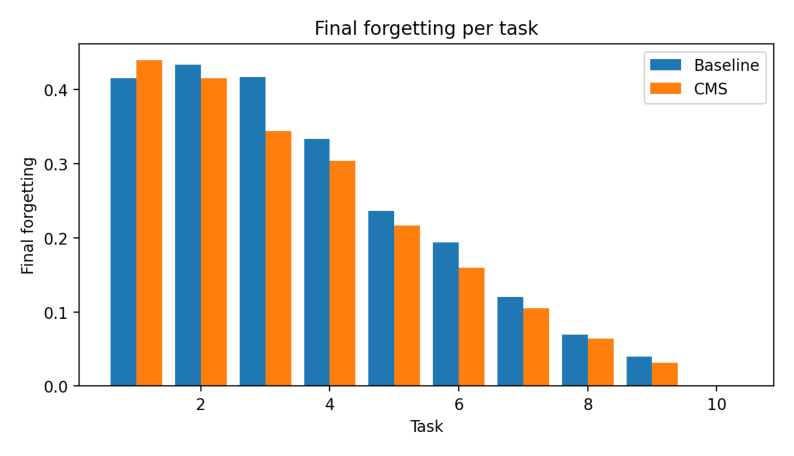

In [7]:
show_figure(FIG_DIR / "final_forgetting_per_task.png")

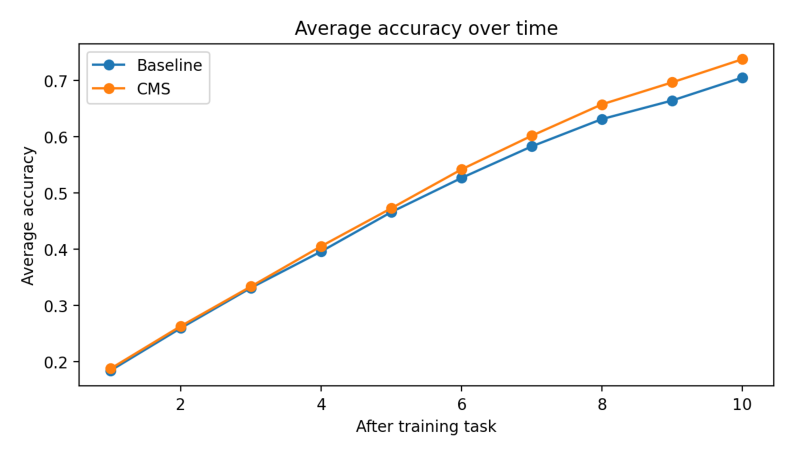

In [8]:
show_figure(FIG_DIR / "avg_accuracy_over_time.png")

## Conclusion

- **Sequential CMS consistently outperforms the baseline MLP** in average accuracy across runs and achieves **lower average forgetting**.

- **Plot analysis** shows that CMS improves accuracy and forgetting consistently overtime in continual learning environments.

- **Paired statistical tests** confirm that these gains are statistically significant.

Overall, the results show that **multi-timescale Sequential CMS** **significantly improves continual learning stability** on by both increasing average accuracy and reducing catastrophic forgetting compared to the baseline.